In [1]:
! python --version

Executing run.sh inside /Users/bartoszlachowicz/Desktop/Codeprojects/mac-bash-commands/goto/run.sh
Executing run.sh inside /Users/bartoszlachowicz/Desktop/Codeprojects/mac-bash-commands/python-venv/run.sh
zsh:1: command not found: python


In [77]:
!source .venv/bin/activate
import warnings
warnings.filterwarnings('ignore')


Executing run.sh inside /Users/bartoszlachowicz/Desktop/Codeprojects/mac-bash-commands/goto/run.sh
Executing run.sh inside /Users/bartoszlachowicz/Desktop/Codeprojects/mac-bash-commands/python-venv/run.sh


In [133]:
import os
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from copy import deepcopy

#printing
from torch_geometric import utils
# import networkx as nx

# Torch
from torch_geometric.nn import GCNConv, TransformerConv, GATConv
from torch.utils.data import random_split, SubsetRandomSampler, Subset
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from typing import Dict, Tuple


import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [135]:
Edges = Dict[Tuple[int, int], Tuple[int, ...]]
Nodes = Dict[int, Tuple[int, ...]]
all_edges: Dict[Tuple[int, int], Tuple[int, ...]] = {}

# class CustomDataset(Dataset):
#     def __init__(self, data_list):
#         self.data_list = data_list

#     def __getitem__(self, index):
#         return self.data_list[index]

#     def __len__(self):
#         return len(self.data_list)

def datasets(data_directory):
    datasets = {}
    for domain_name in os.listdir(data_directory):
        domain_path = os.path.join(data_directory, domain_name)
        data_loader = dataset_from_domain(domain_path)
        datasets[domain_name] = data_loader
    return datasets

def dataset_from_domain(domain_path):
    domain_name = os.path.basename(domain_path)
    dataset = []
    number_of_problems = 0
    for problem_name in os.listdir(domain_path):
        if problem_name == "empty_causal_graphs":
            continue
        number_of_problems+=1
        problem_path = os.path.join(domain_path, problem_name)
        data = problem_path_to_data(problem_path)
        dataset.append(data)
        # Generate list of data objects from our problem path
        
        # Iterate over all the problems in the domain
        # Generate a data object for each problem
        # train_test_split everything
        # train the model
    return dataset




def split_dataset(dataset, test_size=0.2, batch_size=8, shuffle=True, random_seed=42) -> Tuple[DataLoader, DataLoader]:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(0.2 * dataset_size))
    if True :
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, test_indicies = indices[split:], indices[:split]

    train_set = []
    test_set = []

    for i in range(len(satellite_dataset)):
        if i in train_indices:
            train_set.append(satellite_dataset[i])
        else:
            test_set.append(satellite_dataset[i])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    return train_loader, test_set

    

def problem_path_to_data(problem_path):
    # print(problem_path)
    cg_df = pd.read_csv(os.path.join(problem_path, 'cg.csv'), index_col=[0, 1])
    cg_df.sort_index(inplace=True)
    nodes_df = pd.read_csv(os.path.join(problem_path, 'nodes.csv'), index_col=0)
    print(nodes_df.info())

    edges = cg_df.index
    edge_features_list = cg_df[['type_pre_eff', 'type_eff_eff']].values
    edge_labels = cg_df['label'].values
    edge_dict = {}

    # Unlucky naming, but the edge_features is a vector representing features of a single edge
    # edge_feature_list is the dictionary of all the edges and their respective features
    for edge, edge_features, label in zip(edges, edge_features_list, edge_labels):
        edge_dict[tuple(edge)] = (edge_features, label)

    edge_features, edge_labels = zip(*[edge_dict[edge] for edge in sorted(edge_dict.keys())])


    data = Data(
        x=torch.tensor(nodes_df.values, dtype=torch.float),
        edge_index=torch.tensor(list(sorted(edge_dict.keys())), dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_features, dtype=torch.float),
        y=torch.tensor(edge_labels, dtype=torch.float)
    )
    return data

    
def draw_graph(data: Data):
    g = utils.to_networkx(data)

    color = ['green' if data.y[i] else 'red' for i in range(data.y.size(0))]
    a = nx.draw_networkx(g,node_size=200, pos=nx.spectral_layout(g), edge_color=color, node_color='green', with_labels=True)

satellite_dataset = dataset_from_domain('graph_training_data/satellite')
train_loader, test_set = split_dataset(satellite_dataset)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_goal      18 non-null     int64
 1   num_options  18 non-null     int64
dtypes: int64(2)
memory usage: 432.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_goal      20 non-null     int64
 1   num_options  20 non-null     int64
dtypes: int64(2)
memory usage: 480.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_goal      21 non-null     int64
 1   num_options  21 non-null     int64
dtypes: int64(2)
memory usage: 504.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13


In [136]:
class Net(torch.nn.Module):
    def __init__(self, features_num):
        super(Net, self).__init__()
        self.conv1 = GATConv(
            in_channels=features_num,
            out_channels=64,
            edge_dim=2
        )
        self.conv2 = GATConv(
            in_channels=64,
            out_channels=64,
            edge_dim=2)

        self.conv3 = GATConv(
            in_channels=64,
            out_channels=32,
            edge_dim=2)

    def encode(self, data: Data):
        x = self.conv1(
            x=data.x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr) # convolution 1
        x = x.relu()
        x = self.conv2(
            x=x, 
            edge_index=data.edge_index,
            edge_attr=data.edge_attr) # convolution 2
        x = x.relu()
        return self.conv3(
            x=x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr) # convolution 3

    def decode(self, z, edge_index): # only pos and neg edges
        #TODO  edge_index[0] 7 4 9
        #TODO edge_index[1] 5 3 9
        #     print("z shape: ", z.shape)

        # Multiply adjecency matrix with latent space using the COO format of 
        # Edge index[0] and Edge index[1]
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 


        return logits

    # def decode_all(self, z): 
    #     prob_adj = z @ z.t() # get adj NxN
    #     return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [137]:
data_loader = train_loader
test_loader = DataLoader(test_set, batch_size=150)

num_node_features = next(iter(data_loader)).x.shape[1]
model = Net(num_node_features)
optimizer = torch.optim.Adam(params=model.parameters())
batch = next(iter(data_loader))
print(batch[0].x.shape)
print(batch[1].x.shape)

torch.Size([14, 2])
torch.Size([14, 2])


In [138]:
for b in test_loader:
    print('a')

a


In [139]:

def train():
    model.train()  # Flag to modify the gradient

    batch = next(iter(data_loader))  # This is next level shit
    # print(batch[0])
    # print(batch[1])
    edge_index = batch.edge_index
    optimizer.zero_grad()
    z = model.encode(batch)
    link_logits = model.decode(z, edge_index) # decode
    # print(link_logits.shape)
    link_labels = batch.y
    # print(link_labels)
    link_labels = link_labels.type(torch.float)
    # print(link_labels)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    test_data = next(iter(test_loader))
    z = model.encode(test_data) # encode train
    link_logits = model.decode(z, test_data.edge_index) # decode test or val
    # link_probs = link_logits.sigmoid() # apply sigmoid
    link_labels = test_data.y.type(torch.float)

    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    return loss, link_logits, link_labels
    # return roc_auc_score(link_labels, link_probs) #compute roc_auc score

In [140]:
best_val_perf = test_perf = 0
epoch_list = []
loss_list = []
test_perf_list = []
for epoch in range(1, 150):
    train_loss = train()

    test_perf, _, _ = test()
    # if val_perf > best_val_perf:
    #     best_val_perf = val_perf
    #     test_perf = tmp_test_perf
    # log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    log = 'Epoch: {:03d}, Loss: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        epoch_list.append(epoch)
        loss_list.append(train_loss.item())
        test_perf_list.append(test_perf)
        print(log.format(epoch, train_loss, test_perf))

Epoch: 010, Loss: 1.3011, Test: 1.1388
Epoch: 020, Loss: 0.7268, Test: 0.7485
Epoch: 030, Loss: 0.7074, Test: 0.7137
Epoch: 040, Loss: 0.7046, Test: 0.7049
Epoch: 050, Loss: 0.6940, Test: 0.7022
Epoch: 060, Loss: 0.6740, Test: 0.7009
Epoch: 070, Loss: 0.6832, Test: 0.6994
Epoch: 080, Loss: 0.6862, Test: 0.6978
Epoch: 090, Loss: 0.6944, Test: 0.6964
Epoch: 100, Loss: 0.7032, Test: 0.6959
Epoch: 110, Loss: 0.6940, Test: 0.6954
Epoch: 120, Loss: 0.6974, Test: 0.6953
Epoch: 130, Loss: 0.6901, Test: 0.6953
Epoch: 140, Loss: 0.6904, Test: 0.6952


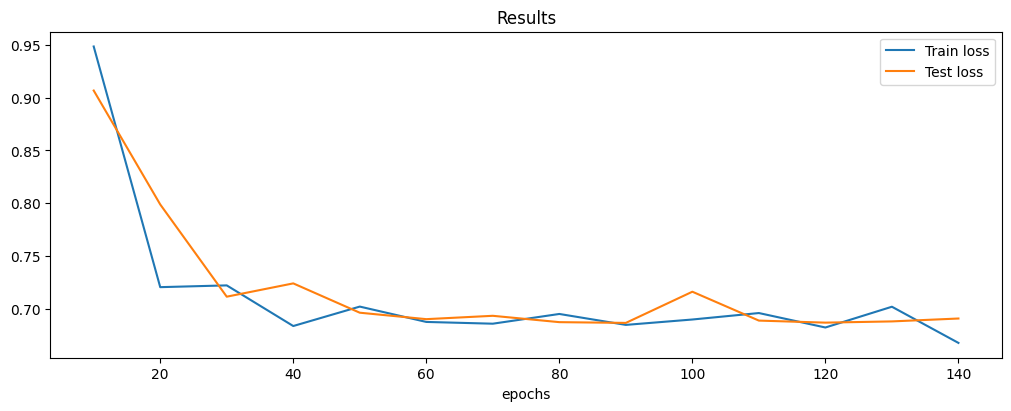

In [127]:

fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
ax.plot(epoch_list, loss_list, label='Train loss')  
ax.plot(epoch_list, test_perf_list, label='Test loss') 
ax.set_xlabel('epochs')
ax.set_title("Results") 
ax.legend();  

In [128]:
from sklearn.metrics import precision_recall_fscore_support

def plot_recalls(treshold, result, bar_width):
    # bar_width = 0.005

    recall_positive = result[0]
    recall_negative = result[1]
    plt.title("Visualization of recall for positive and negative class")
    plt.legend(['Positive', 'Negative'], loc='best')
    plt.xlabel("Fixed treshold value")
    plt.ylabel("Recall %")

    plt.bar(treshold + bar_width/2, recall_positive, bar_width,  color='green', label='Positive')
    plt.bar(treshold - bar_width/2, recall_negative, bar_width, color='red', label='Negative')



def plot_all_recalls(data, bar_width):
    # f = plt.figure(figsize=(10, 5))

    # f.legend()
    # f.yticks(np.arange(0, 105, 5))

    for treshold, result in data.items():
        plot_recalls(treshold, result, bar_width)
    plt.grid(axis='y', alpha=0.4)
    plt.show()



In [129]:
def treshhold_result(data, true_data, treshold):
    changed_data = (data >= treshold).astype(int)
    recall_positive = precision_recall_fscore_support(true_data, changed_data, average=None)[1][1] * 100
    recall_negative = precision_recall_fscore_support(true_data, changed_data, average=None)[1][0] * 100
 
    return recall_positive, recall_negative

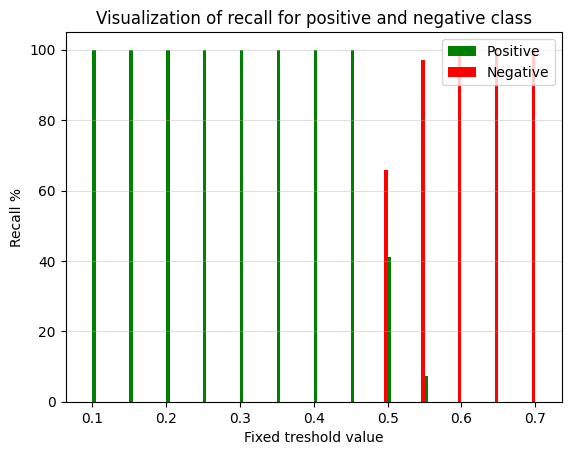

In [130]:

# target, preds = test()
# target_conf.append(target)
# preds_conf.append(preds)

loss, encode_values, true_labels= test()

predicted_logits = encode_values.sigmoid()

# target, pred = evaluate_and_return_confusion()


preds_final = torch.tensor(predicted_logits)
target_final = torch.tensor(true_labels)


tresholds = np.arange(0.1, 0.75, 0.05)

data = {}
for treshold in tresholds:
    result = treshhold_result(data = preds_final.numpy(), true_data=target_final.numpy(), treshold=treshold)
    data[treshold] = result
    
plt.plot()
plot_all_recalls(
    data,
    bar_width=0.005)

In [68]:
# give me postive and negative value for true_labels and print it
neg = true_labels.count_nonzero()
pos = true_labels.shape[0] - neg
print("Positive: ", pos)
print("Negative: ", neg)

Positive:  tensor(826)
Negative:  tensor(595)
